# 4-Q4.2

In [1]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader,Subset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.nn.functional import one_hot

In [47]:
# activation function
def sigmoid(values):
    
    return 1/(1+np.exp(-values))

def softmax(values):
    exp_values = np.exp(values)
    exp_values_sum = np.sum(exp_values)
 
    return exp_values/exp_values_sum

# NN function
class myNN():
    def __init__(self,d1 = 300,lr = 0.035):
        self.d1 = d1
        self.lr = lr #learning rate
        self.W1 = torch.rand(d1,28*28) - .5
        self.W2 = torch.rand(10,d1) - .5


    def forward(self,x):
        x = torch.flatten(x,start_dim=1)
        x = x.T
        z1 = torch.matmul(self.W1,x)
        h = torch.sigmoid(z1)
        z2 = torch.matmul(self.W2,h)
        y_hat = torch.softmax(z2,dim=0)
        return y_hat, z2, h, z1, x
    
    def train_loop(self, train_dataloader, batch_size):
        W2 = self.W2.clone()
        W1 = self.W1.clone()
        lr =self.lr
        idx = np.random.randint(len(train_dataloader), size=50, dtype=int)
        for batch, (X,y) in enumerate(train_dataloader):
            dW1 = torch.zeros(self.d1,28*28)
            dW2 = torch.zeros(10,self.d1)
            if batch in idx:
                for i in range(batch_size):
                    one_hot_y = one_hot(y[i],num_classes=10)
                    y_hat, _, h, _, x  = self.forward(X[i])
                    a = y_hat.T-one_hot_y
                    dW2 += torch.matmul(a.T,h.T)
                    temp = h*(1-h)[:,0]
                    diag =   torch.diag(temp)
                    dW1 +=  diag @ W2.T @ a.T @ x.T
                W1 = W1 - lr/batch_size * dW1
                W2 = W2 - lr/batch_size * dW2
                self.W1 = W1
                self.W2 = W2

    def test_loop(self,test_dataloader,loos_fn, batch_size):
#         size = len(test_dataloader.dataset)
#         num_batches = len(test_dataloader)
        correct = 0

        (X_test,Y_test) = next(iter(test_dataloader))
        for i in range(batch_size):
            pred, _, _, _ , _ = self.forward(X_test[i])
            y = one_hot(Y_test[i],num_classes=10)
#             loss = loss_fn
#             test_loss += loss(pred, y).item()
            correct += (torch.argmax(y).numpy()==torch.argmax(pred).numpy())#.type(torch.float).sum().item()

        correct =  correct/batch_size
        return correct
        

In [3]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)   
        

In [53]:
epochs = 45
m = 32 #batch size
learning_rate = .035

train_dataloader = DataLoader(training_data,batch_size = m)
test_dataloader = DataLoader(test_data, batch_size=m)
test_err = np.zeros(epochs)
NN = myNN()

loss_fn = nn.CrossEntropyLoss()
for i in range(epochs):
    print(f"Epoch {i+1} ")
    NN.train_loop(train_dataloader,m)
    
    acc = NN.test_loop(test_dataloader, loss_fn, m)
    print("Test error:", 100*(1-acc), "% \n")
    test_err[i] = 100*(1-acc)
print("Done!")

Epoch 1 
Test error: 87.5 % 

Epoch 2 
Test error: 87.5 % 

Epoch 3 
Test error: 84.375 % 

Epoch 4 
Test error: 75.0 % 

Epoch 5 
Test error: 71.875 % 

Epoch 6 
Test error: 59.375 % 

Epoch 7 
Test error: 59.375 % 

Epoch 8 
Test error: 59.375 % 

Epoch 9 
Test error: 56.25 % 

Epoch 10 
Test error: 56.25 % 

Epoch 11 
Test error: 53.125 % 

Epoch 12 
Test error: 43.75 % 

Epoch 13 
Test error: 43.75 % 

Epoch 14 
Test error: 37.5 % 

Epoch 15 
Test error: 34.375 % 

Epoch 16 
Test error: 28.125 % 

Epoch 17 
Test error: 25.0 % 

Epoch 18 
Test error: 25.0 % 

Epoch 19 
Test error: 18.75 % 

Epoch 20 
Test error: 15.625 % 

Epoch 21 
Test error: 18.75 % 

Epoch 22 
Test error: 12.5 % 

Epoch 23 
Test error: 9.375 % 

Epoch 24 
Test error: 15.625 % 

Epoch 25 
Test error: 9.375 % 

Epoch 26 
Test error: 9.375 % 

Epoch 27 
Test error: 9.375 % 

Epoch 28 
Test error: 9.375 % 

Epoch 29 
Test error: 9.375 % 

Epoch 30 
Test error: 9.375 % 

Epoch 31 
Test error: 9.375 % 

Epoch 32 
Test

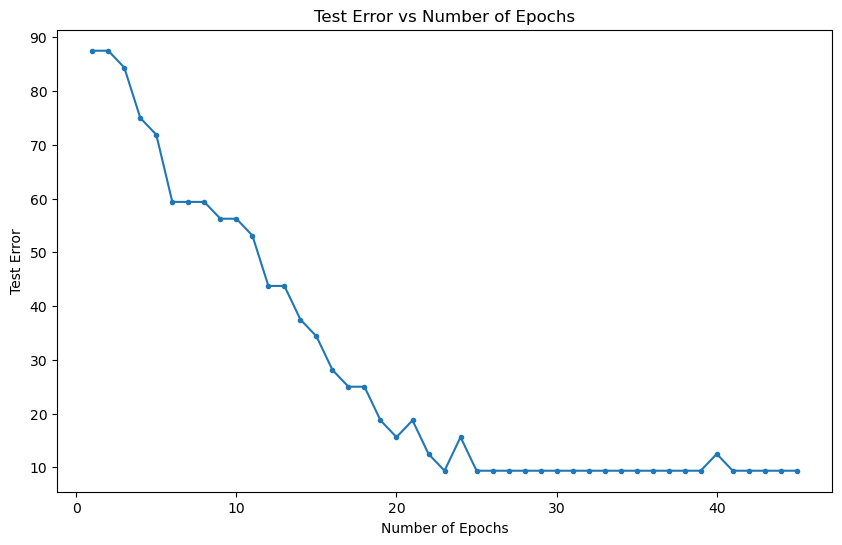

In [54]:
import matplotlib.pyplot as plt

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1,epochs+1), test_err, linestyle='-',marker = 'o',markersize = 3)
plt.title('Test Error vs Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Test Error')
# Display the plot
plt.show()


## 4-Q4.3

In [55]:
import torch
from torch import nn
from torch.utils.data import DataLoader,Subset
from torchvision import datasets
from torchvision.transforms import ToTensor

d1=300
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_sig_stack = nn.Sequential(
            nn.Linear(28*28, d1,bias = False),
            nn.Sigmoid(),
            nn.Linear(d1, 10,bias = False),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_sig_stack(x)
        return logits

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    correct = 0

    # torch.no_grad() means that no gradients are computed during test mode
    with torch.no_grad():
        (X_test,Y_test_test) = next(iter(test_dataloader))
        X, y = X_test.to(device), Y_test.to(device)
        pred = model(X)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    correct /= size
    return 1-correct


loss_fn = nn.CrossEntropyLoss()

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



Using cpu device


In [60]:
epochs = 30
learning_rate = .01

test_error1 = torch.zeros(epochs)
model = NeuralNetwork()

for layer in model.modules():
    if isinstance(layer, nn.Linear):
        layer.weight.data.uniform_(-1,1)
model = model.to(device=device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for i in range(epochs):
    print('Epochs',i+1)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    
    err = test_loop(test_dataloader, model, loss_fn)
    test_error1[i] = err
    print(f"Test Error: {(100*err):>0.1f}% \n")
print("Done!")

Epochs 1
Test Error: 
 22.4% 

Epochs 2
Test Error: 
 15.4% 

Epochs 3
Test Error: 
 12.8% 

Epochs 4
Test Error: 
 11.4% 

Epochs 5
Test Error: 
 10.6% 

Epochs 6
Test Error: 
 10.3% 

Epochs 7
Test Error: 
 10.0% 

Epochs 8
Test Error: 
 9.7% 

Epochs 9
Test Error: 
 9.4% 

Epochs 10
Test Error: 
 9.1% 

Epochs 11
Test Error: 
 8.9% 

Epochs 12
Test Error: 
 8.8% 

Epochs 13
Test Error: 
 8.7% 

Epochs 14
Test Error: 
 8.5% 

Epochs 15
Test Error: 
 8.4% 

Epochs 16
Test Error: 
 8.4% 

Epochs 17
Test Error: 
 8.3% 

Epochs 18
Test Error: 
 8.2% 

Epochs 19
Test Error: 
 8.1% 

Epochs 20
Test Error: 
 8.0% 

Epochs 21
Test Error: 
 7.9% 

Epochs 22
Test Error: 
 7.8% 

Epochs 23
Test Error: 
 7.7% 

Epochs 24
Test Error: 
 7.7% 

Epochs 25
Test Error: 
 7.6% 

Epochs 26
Test Error: 
 7.6% 

Epochs 27
Test Error: 
 7.5% 

Epochs 28
Test Error: 
 7.4% 

Epochs 29
Test Error: 
 7.4% 

Epochs 30
Test Error: 
 7.3% 

Done!


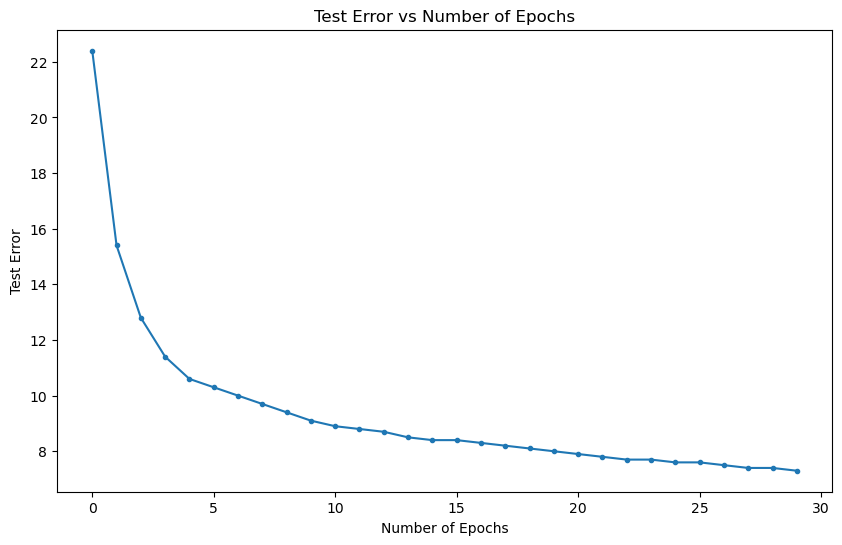

In [66]:
import matplotlib.pyplot as plt

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(epochs),100*test_error1, linestyle='-',marker = 'o',markersize = 3)
plt.title('Test Error vs Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Test Error')
# Display the plot
plt.show()


## 4-Q4.4

In [64]:
epochs = 30
learning_rate = .01

test_error2 = torch.zeros(epochs)
model = NeuralNetwork()

for layer in model.modules():
    if isinstance(layer, nn.Linear):
        layer.weight.data.zero_()
model = model.to(device=device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for i in range(epochs):
    print('Epochs',i+1)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    
    err = test_loop(test_dataloader, model, loss_fn)
    test_error2[i] = err
    print(f"Test Error: {(100*err):>0.1f}% \n")
print("Done!")

Epochs 1
Test Error: 
 90.4% 

Test Error: 90.4% 

Epochs 2
Test Error: 
 90.4% 

Test Error: 90.4% 

Epochs 3
Test Error: 
 90.4% 

Test Error: 90.4% 

Epochs 4
Test Error: 
 90.4% 

Test Error: 90.4% 

Epochs 5
Test Error: 
 88.6% 

Test Error: 88.6% 

Epochs 6
Test Error: 
 88.6% 

Test Error: 88.6% 

Epochs 7
Test Error: 
 88.6% 

Test Error: 88.6% 

Epochs 8
Test Error: 
 88.6% 

Test Error: 88.6% 

Epochs 9
Test Error: 
 87.5% 

Test Error: 87.5% 

Epochs 10
Test Error: 
 74.4% 

Test Error: 74.4% 

Epochs 11
Test Error: 
 70.8% 

Test Error: 70.8% 

Epochs 12
Test Error: 
 68.6% 

Test Error: 68.6% 

Epochs 13
Test Error: 
 66.4% 

Test Error: 66.4% 

Epochs 14
Test Error: 
 64.2% 

Test Error: 64.2% 

Epochs 15
Test Error: 
 62.8% 

Test Error: 62.8% 

Epochs 16
Test Error: 
 61.9% 

Test Error: 61.9% 

Epochs 17
Test Error: 
 61.2% 

Test Error: 61.2% 

Epochs 18
Test Error: 
 60.6% 

Test Error: 60.6% 

Epochs 19
Test Error: 
 60.0% 

Test Error: 60.0% 

Epochs 20
Test Error:

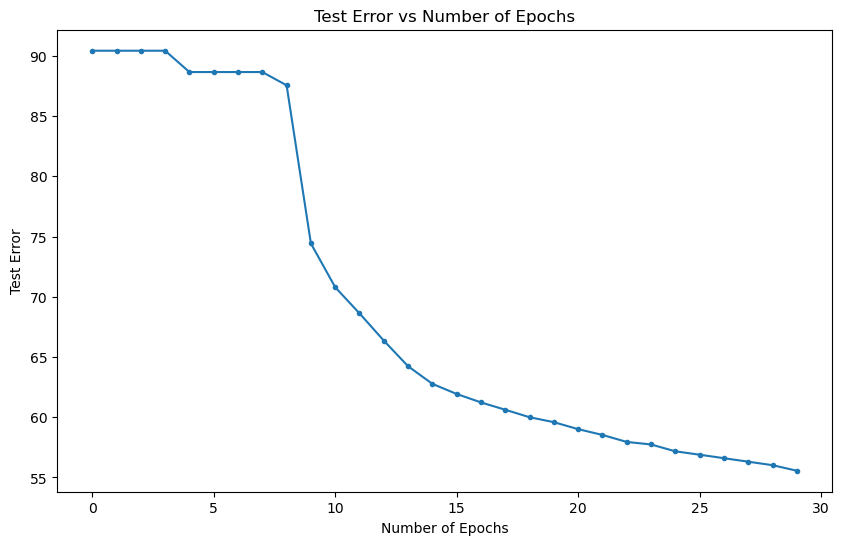

In [65]:
import matplotlib.pyplot as plt

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), 100*test_error2, linestyle='-',marker = 'o',markersize = 3)
plt.title('Test Error vs Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Test Error')
# Display the plot
plt.show()


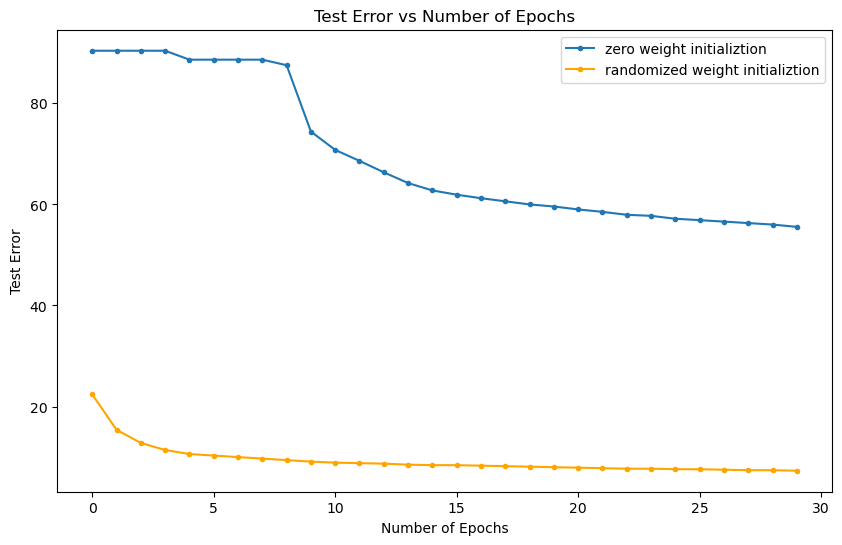

In [68]:
import matplotlib.pyplot as plt

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), 100*test_error2, linestyle='-',marker = 'o',markersize = 3,
         label='zero weight initializtion')
plt.plot(range(epochs), 100*test_error1, linestyle='-',marker = 'o',markersize = 3, color = 'orange',
         label='randomized weight initializtion')
plt.legend(loc='best')
plt.title('Test Error vs Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Test Error')
# Display the plot
plt.show()